<a href="https://colab.research.google.com/github/semmatoninn/CHE1147/blob/main/PLGAmicroparticles_ML%20Project%20Code_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Data Preparation

In [62]:
RANDOM_SEED = 1147

In [63]:
import pandas as pd
import numpy as np

!pip install rdkit
from rdkit import Chem # module chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import PandasTools # module from rdkit.Chem

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    max_error
)

from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge

from xgboost import XGBRegressor

!pip install shap
import shap

In [64]:
!git clone https://github.com/semmatoninn/CHE1147.git
%cd CHE1147
import pandas as pd
df = pd.read_excel("mp_dataset_initial.xlsx")
df.head()


Cloning into 'CHE1147'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.98 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/CHE1147/CHE1147/CHE1147


,Formulation Index,Drug,Drug SMILES,Polymer Mw (kDa),Polymer Mn (kDa),Polymer Molecular Weight (kDa),PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w),DOI
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,10.3390/ijms241914729
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,10.3390/ijms241914729
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,10.3390/ijms241914729
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,10.3390/ijms241914729
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,10.3390/ijms241914729


In [65]:
df.shape

(4913, 17)

In [66]:
df.columns


Index(['Formulation Index', 'Drug', 'Drug SMILES', 'Polymer Mw (kDa)',
       'Polymer Mn (kDa)', 'Polymer Molecular Weight (kDa)', 'PDI', 'LA/GA',
       'Formulation Method', 'Initial Drug-to-Polymer Ratio',
       'Particle Size (μm)', 'Drug Loading Capacity (%)',
       'Drug Encapsulation Efficiency (%)',
       'Solubility Enhancer Concentration (%)', 'Time (days)', 'Release (w/w)',
       'DOI'],
      dtype='object')

In [67]:
df.info() # 17 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Formulation Index                      4913 non-null   int64  
 1   Drug                                   4913 non-null   object 
 2   Drug SMILES                            4913 non-null   object 
 3   Polymer Mw (kDa)                       2933 non-null   float64
 4   Polymer Mn (kDa)                       291 non-null    float64
 5   Polymer Molecular Weight (kDa)         1868 non-null   float64
 6   PDI                                    179 non-null    float64
 7   LA/GA                                  4913 non-null   float64
 8   Formulation Method                     4913 non-null   object 
 9   Initial Drug-to-Polymer Ratio          4913 non-null   float64
 10  Particle Size (μm)                     4913 non-null   float64
 11  Drug

In [68]:
df.describe()

,Formulation Index,Polymer Mw (kDa),Polymer Mn (kDa),Polymer Molecular Weight (kDa),PDI,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w)
count,4913.000000,2933.000000,291.000000,1868.000000,179.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000
mean,159.926114,39.053910,23.696117,42.262141,1.694134,1.573165,0.254164,45.146116,12.880814,68.043714,1.004701,13.243417,0.525642
std,90.672849,28.783147,19.395257,32.187646,0.299379,0.978081,0.258735,45.053940,10.537514,21.832433,4.539232,17.634423,0.327611
min,1.000000,5.000000,2.300000,5.000000,1.300000,1.000000,0.000500,1.153000,0.022178,1.310000,0.000000,0.000000,0.000000
25%,85.000000,12.000000,6.100000,20.000000,1.300000,1.000000,0.100000,16.094710,4.800000,52.100000,0.000000,2.689872,0.218181
50%,152.000000,31.000000,10.000000,34.000000,1.710000,1.000000,0.200000,35.000000,9.320000,71.800000,0.000000,8.043956,0.571429
75%,241.000000,46.000000,32.000000,46.000000,1.960000,3.000000,0.250000,60.200000,17.982000,85.500000,0.100000,18.076366,0.824176
max,321.000000,104.000000,57.500000,215.000000,2.190000,5.670000,1.718876,295.700000,61.900000,100.000000,30.000000,237.732283,1.081614


In [69]:
df.head(10)

,Formulation Index,Drug,Drug SMILES,Polymer Mw (kDa),Polymer Mn (kDa),Polymer Molecular Weight (kDa),PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w),DOI
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,10.3390/ijms241914729
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,10.3390/ijms241914729
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,10.3390/ijms241914729
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,10.3390/ijms241914729
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,10.3390/ijms241914729
5,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,48.755906,0.048924,10.3390/ijms241914729
6,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,62.740157,0.045010,10.3390/ijms241914729
7,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,69.543307,0.045010,10.3390/ijms241914729
8,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,76.724409,0.046967,10.3390/ijms241914729
9,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,107.716535,0.082192,10.3390/ijms241914729


**Dropping Source link Column - No predictive value**

In [70]:
df = df.drop(columns = 'DOI')
print(f"After dropping columns: the number of columns are {df.shape[1]}")

After dropping columns: the number of columns are 16


## **Null Values**

In [71]:
print(f"The number of nulls in df: {df.isna().sum().sum()}")

The number of nulls in df: 14381


In [72]:
df.isna().sum().sort_values(ascending=False)

,0
PDI,4734
Polymer Mn (kDa),4622
Polymer Molecular Weight (kDa),3045
Polymer Mw (kDa),1980
Drug SMILES,0
Drug,0
Formulation Index,0
LA/GA,0
Formulation Method,0
Initial Drug-to-Polymer Ratio,0


In [73]:
# Drop columns with too many missing values - 4 columns dropped
df = df.drop(columns=['PDI', 'Polymer Mn (kDa)',"Polymer Mw (kDa)","Polymer Molecular Weight (kDa)"])
print(f"After dropping columns: the number of columns are {df.shape[1]}")

After dropping columns: the number of columns are 12


## Duplicates

In [74]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True) # dropping duplicates

Number of duplicated rows: 2


## **Zero variance columns**

In [75]:
zero_var_cols = df.columns[df.nunique() == 1].tolist()
print("Zero-variance columns:", zero_var_cols)


Zero-variance columns: []


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4911 entries, 0 to 4912
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Formulation Index                      4911 non-null   int64  
 1   Drug                                   4911 non-null   object 
 2   Drug SMILES                            4911 non-null   object 
 3   LA/GA                                  4911 non-null   float64
 4   Formulation Method                     4911 non-null   object 
 5   Initial Drug-to-Polymer Ratio          4911 non-null   float64
 6   Particle Size (μm)                     4911 non-null   float64
 7   Drug Loading Capacity (%)              4911 non-null   float64
 8   Drug Encapsulation Efficiency (%)      4911 non-null   float64
 9   Solubility Enhancer Concentration (%)  4911 non-null   float64
 10  Time (days)                            4911 non-null   float64
 11  Release (

In [77]:
df.head(11)

,Formulation Index,Drug,Drug SMILES,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w)
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708
5,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,48.755906,0.048924
6,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,62.740157,0.045010
7,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,69.543307,0.045010
8,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,76.724409,0.046967
9,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,107.716535,0.082192


## **Canonicalization**

In [78]:
def canonicalize_smiles(smiles, isomeric:bool=True): # isomeric is flag/true or false, true is default
    """
    Convert any SMILES to its canonical form.

    Args:
        smiles (str): Input SMILES string

    Returns:
        str: Canonical SMILES
    """
    mol = Chem.MolFromSmiles(smiles) # creating mol object
    if mol is None:
        return None  # Invalid SMILES
    return Chem.MolToSmiles(mol, isomericSmiles=isomeric)

In [79]:
df['Drug canonical_smiles'] = df['Drug SMILES'].apply(canonicalize_smiles)

In [80]:
df.head()

,Formulation Index,Drug,Drug SMILES,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w),Drug canonical_smiles
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...


In [81]:
# Add a column called 'molecule' with mol objects
PandasTools.AddMoleculeColumnToFrame(df, # AddMoleculeColumnToFrame is a function inside PandasTools module
                                     smilesCol='Drug canonical_smiles', # input column
                                     molCol='Drug molecule' # output column - new column created
                                     ) # creates mol object from canonical smiles column

# df['molecule'] = df['canonical_smiles'].apply(Chem.MolFromSmiles) # the previous line is same as this
df.head()

,Formulation Index,Drug,Drug SMILES,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w),Drug canonical_smiles,Drug molecule
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7374cf0>
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c73763b0>
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c73753f0>
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7375a80>
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7375150>


In [82]:
# Define a function to calculate key molecular descriptors
def calculate_key_descriptors(mol):
    """Calculate key molecular descriptors for a molecule."""

    descriptors = {
        'Drug MW': Descriptors.MolWt(mol),
        'Drug LogP': Descriptors.MolLogP(mol), # Lipophilicity (octanol-water partition coefficient)
        'Drug TPSA': Descriptors.TPSA(mol), # Topological Polar Surface Area (important for drug absorption)
        # 'Drug HBD': Descriptors.NumHDonors(mol),
        # 'Drug HBA': Descriptors.NumHAcceptors(mol)
    }

    return descriptors

# Apply the function to the molecules in the DataFrame
descriptor_data = []
for idx, mol in df['Drug molecule'].items(): # index is row index, mol is molecule column value, molecule is mol object, it is pd series, index value pair
    desc = calculate_key_descriptors(mol) # dictionary created for each sample molecule
    descriptor_data.append(desc)

# Create descriptor DataFrame with pd.DataFrame()
# We use the same index as the original DataFrame to maintain row alignment
descriptor_df = pd.DataFrame(descriptor_data, index=df.index) # new dataframe created with descriptor columns

# Combine with the original molecules DataFrame
df_with_descriptors = pd.concat([df, descriptor_df], axis=1) # axis = 1, side by side concatenation

# Check the new dimensions - we should have the same number of rows but more columns
print(f"Dataset shape: {df_with_descriptors.shape}")
df_with_descriptors.head()

Dataset shape: (4911, 17)


,Formulation Index,Drug,Drug SMILES,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size (μm),Drug Loading Capacity (%),Drug Encapsulation Efficiency (%),Solubility Enhancer Concentration (%),Time (days),Release (w/w),Drug canonical_smiles,Drug molecule,Drug MW,Drug LogP,Drug TPSA
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7374cf0>,639.83,5.7289,116.04
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c73763b0>,639.83,5.7289,116.04
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c73753f0>,639.83,5.7289,116.04
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7375a80>,639.83,5.7289,116.04
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7820c7375150>,639.83,5.7289,116.04


## Train test split

In [83]:
# One-hot encode Formulation Method
TARGET = "Release (w/w)"
df_encoded = pd.get_dummies(
    df_with_descriptors,
    columns=["Formulation Method"],
    drop_first=True
)

# Define FEATURES (exclude target + string/RDKit fields)
exclude_cols = [
    TARGET,
    "Drug",
    "Drug SMILES",
    "Drug canonical_smiles",
    "Drug molecule",
    "Formulation Index"
]

FEATURES = [col for col in df_encoded.columns if col not in exclude_cols]

# Group-aware train/test split (no leakage)
from sklearn.model_selection import GroupShuffleSplit

groups = df_encoded["Formulation Index"]

gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_SEED)

train_idx, test_idx = next(gss.split(df_encoded, groups=groups))

#  Final datasets
X_train = df_encoded.iloc[train_idx][FEATURES]
X_test  = df_encoded.iloc[test_idx][FEATURES]

y_train = df_encoded.iloc[train_idx][TARGET]
y_test  = df_encoded.iloc[test_idx][TARGET]

# Looking at shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (3938, 13)
X_test: (973, 13)
y_train: (3938,)
y_test: (973,)


## Correlation analysis

### Pearson

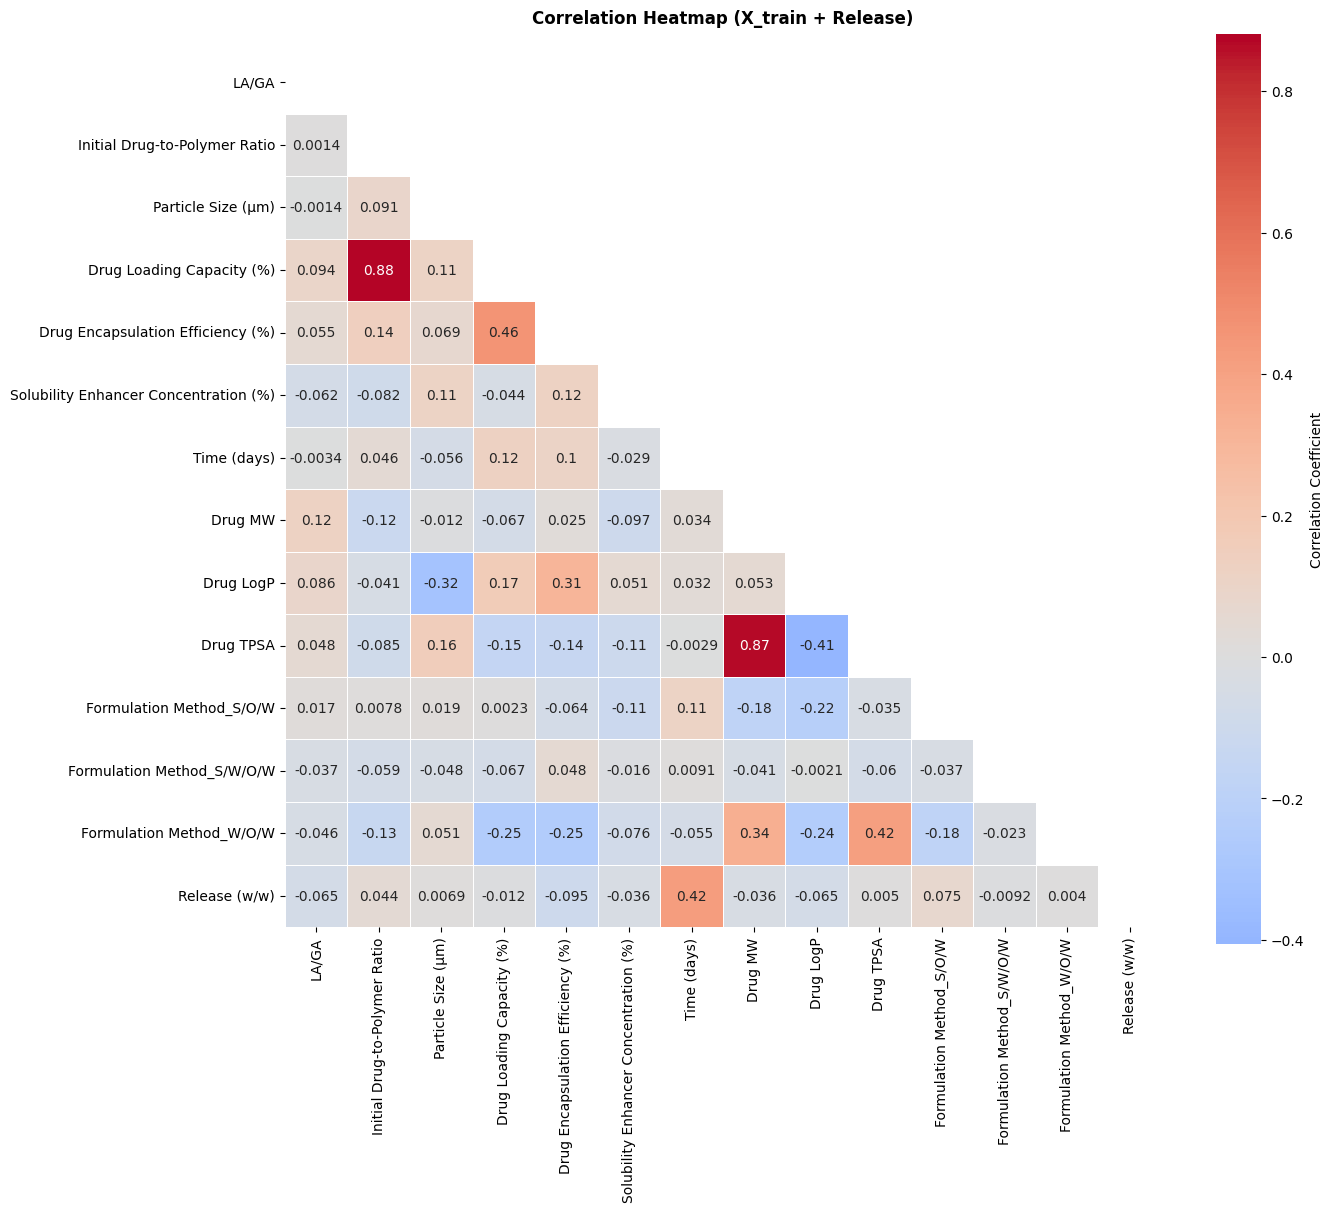

In [84]:
df_corr = X_train.copy()
df_corr["Release (w/w)"] = y_train.values  # Add target column

# Compute correlation
corr_train = df_corr.corr(method="pearson")

plt.figure(figsize=(14, 12))

# Mask upper triangle for cleaner plot
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.heatmap(
    corr_train,
    mask=mask,
    cmap='coolwarm',
    annot=True,   # Set True to show numbers
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap (X_train + Release)", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In Pearson correlation - linear correlations are captured

Highest correlations between features are in

Drug loading capacity - Initial drug to polymer ratio 0.88

Drug TPSA and MW 0.87

Drug Encapsulation Efficiency and Drug Loading Capacity 0.46

Highest correlation with target variable release is time 0.42



### Spearman

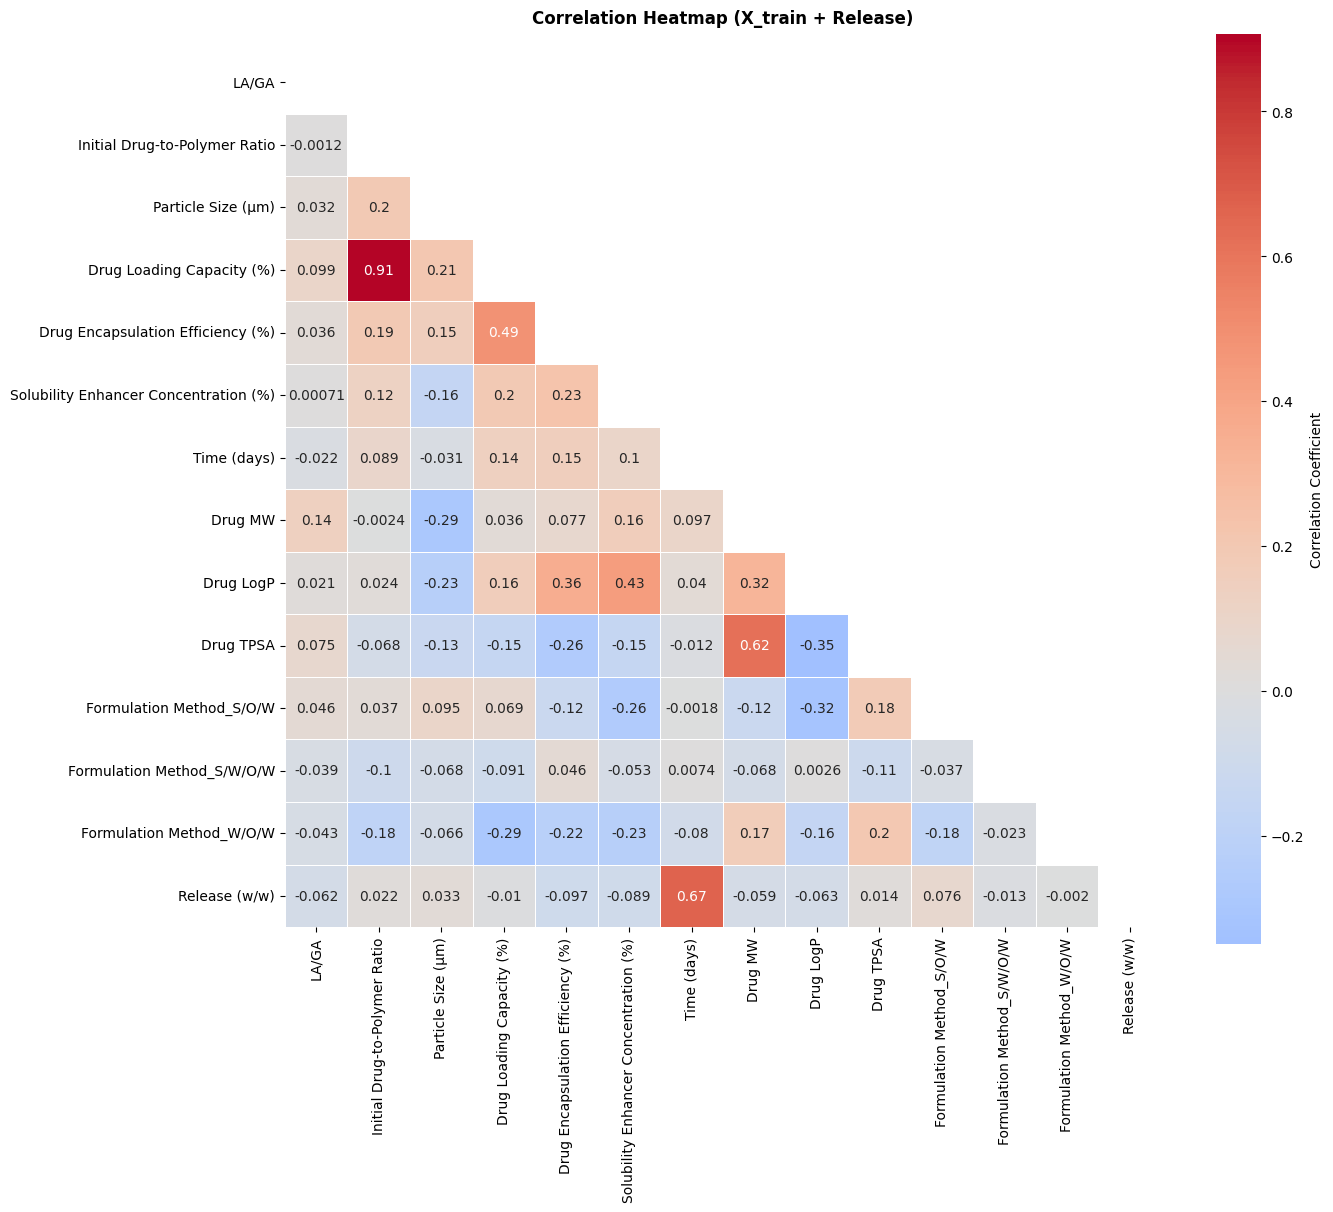

In [85]:

# Compute Spearman correlation
corr_train = df_corr.corr(method="spearman")

plt.figure(figsize=(14, 12))

# Mask upper triangle for cleaner plot
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.heatmap(
    corr_train,
    mask=mask,
    cmap='coolwarm',
    annot=True,   # Set True to show numbers
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap (X_train + Release)", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In Spearman correlations non-linear correlations are also captured, monotonic relationships are captured

Highest correlated features are

Drug loading capacity and initial drug to polymer ratio id 0.91

Drug TPSA and MW correlation is 0.62

Drug encapsulation efficiency and drug loading capacity correlation is 0.49

Drug LogP and Solubility Enhancer Concentration correlation is 0.43

Release and time correlation is 0.67


## Feature Outliers

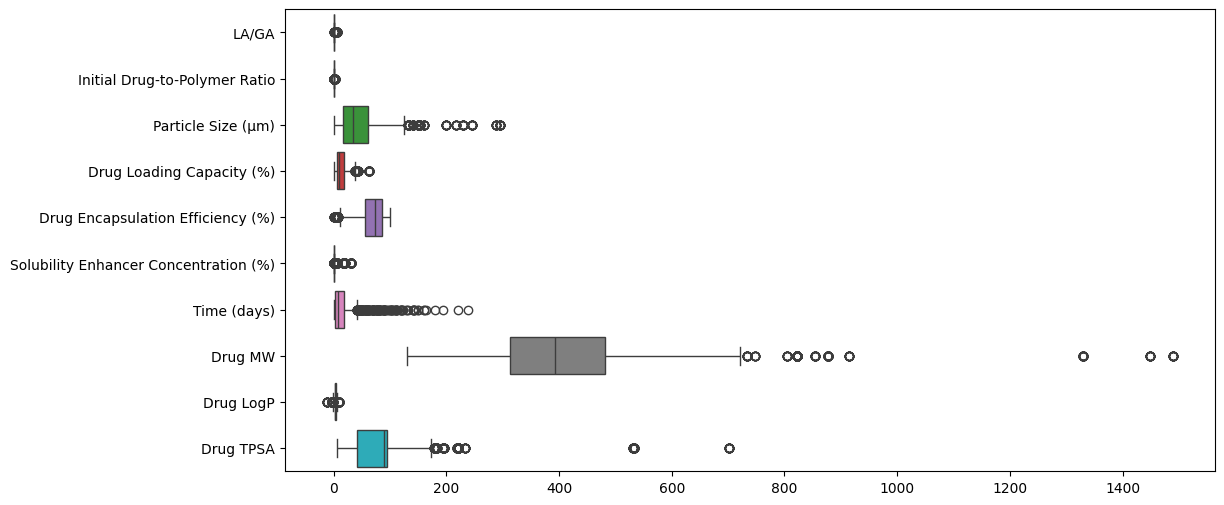

In [86]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 6))
sns.boxplot(X_train[numeric_cols], orient='h')
# plt.tight_layout()
plt.savefig("outlier_detection.png", dpi=300, bbox_inches='tight')
plt.show()

In [87]:
## regular split
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(
#    df[FEATURES], df[TARGET], test_size=0.2, random_state=RANDOM_SEED
#)

# II. Modelling

## Regression

In [88]:

def get_regression_metrics(model, X, y_true):
    """
    Computes stable regression metrics for drug-release prediction.
    MAPE is intentionally excluded because y contains zeros - it explodes.
    """
    # Predictions
    y_pred = model.predict(X)

    # Core metrics
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mxe = max_error(y_true, y_pred)

    return {
        "r2": r2,
        "mse": mse,
        "mae": mae,
        "max_error": mxe
    }


### Linear Regression - Baseline

In [89]:

linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(X_train,y_train)

linear_regressor_results_train = get_regression_metrics(linear_regressor,X_train,y_train )
linear_regressor_results_test = get_regression_metrics(linear_regressor, X_test,y_test )

# Print the results
print("Linear Regression Results - Train Set:", linear_regressor_results_train)
print("Linear Regression Results - Test Set:", linear_regressor_results_test)

Linear Regression Results - Train Set: {'r2': 0.21952167545596735, 'mse': 0.08466056106070305, 'mae': 0.25131539097359107, 'max_error': np.float64(1.454586876178249)}
Linear Regression Results - Test Set: {'r2': 0.19155759595037603, 'mse': 0.08275529764407885, 'mae': 0.2415577889291352, 'max_error': np.float64(0.8166026823196102)}


### Linear Regression with Correlation based feature selection and scaler optimization








In [90]:

# Correlation-based feature filter

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

        # Pearson absolute correlation
        corr = X_df.corr().abs()

        # Upper triangle (no diag)
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        # Choose features to drop
        self.to_drop_ = [
            column
            for column in upper.columns
            if any(upper[column] > self.threshold)
        ]
        return self

    def transform(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        return X_df.drop(columns=self.to_drop_, errors="ignore")


#
# Pipeline: Corr Filter , Scaler , Linear Regression
#    (scaler will be chosen via GridSearch)

pipe = Pipeline([
    ("corr_filter", CorrelationFilter()),
    ("scaler", StandardScaler()),   # placeholder, will be overridden by param_grid
    ("model", LinearRegression())
])

#  Hyperparameter grid
#    correlation threshold
#    scaler type: Standard, MinMax, or no scaling

param_grid = {
    "corr_filter__threshold": [0.75, 0.8, 0.85, 0.9, 0.95],
    "scaler": [
        StandardScaler(),
        MinMaxScaler(),
        "passthrough"   # no scaling
    ]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)


#  Fit on training data
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_model = grid.best_estimator_

linear_corr_train = get_regression_metrics(best_model, X_train, y_train)
linear_corr_test  = get_regression_metrics(best_model, X_test, y_test)

print("Corr-Filtered + Scaler + Linear Regression - Train:", linear_corr_train)
print("Corr-Filtered + Scaler + Linear Regression - Test :", linear_corr_test)

best_filter = best_model.named_steps["corr_filter"]
print("Dropped features at best threshold:", best_filter.to_drop_)

print("Best scaler:", best_model.named_steps["scaler"])


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'corr_filter__threshold': 0.85, 'scaler': MinMaxScaler()}
Best CV R²: 0.130929687508362
Corr-Filtered + Scaler + Linear Regression - Train: {'r2': 0.20658460493123088, 'mse': 0.08606387953177774, 'mae': 0.2550692500424387, 'max_error': np.float64(1.430700526881827)}
Corr-Filtered + Scaler + Linear Regression - Test : {'r2': 0.1959674379466989, 'mse': 0.08230388912673609, 'mae': 0.24494081796760442, 'max_error': np.float64(0.7719873536892092)}
Dropped features at best threshold: ['Drug Loading Capacity (%)', 'Drug TPSA']
Best scaler: MinMaxScaler()


Performance increased very slightly

### Linear Regression with Forward feature selection and scaler optimization



In [91]:
# Base estimator
base_model = LinearRegression()

# Function to generate a forward selector with a given number of features
def make_forward_selector(k):
    return SequentialFeatureSelector(
        estimator=base_model,
        n_features_to_select=k,
        direction="forward",
        scoring="r2",
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

pipe = Pipeline([
    ("scaler", StandardScaler()),      # placeholder (GridSearch will override)
    ("feature_select", make_forward_selector(5)),  # placeholder
    ("model", LinearRegression()),
])


param_grid = {
    "scaler": [
        StandardScaler(),
        MinMaxScaler(),
        "passthrough"              # no scaling
    ],
    "feature_select": [
        make_forward_selector(5),
        make_forward_selector(8),
        make_forward_selector(10),
        make_forward_selector(12)
    ],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the full optimized pipeline
grid.fit(X_train, y_train)

# Best model and parameters
print("Best Params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_model = grid.best_estimator_


train_metrics = get_regression_metrics(best_model, X_train, y_train)
test_metrics  = get_regression_metrics(best_model, X_test, y_test)

print("\nOptimized Forward Selection + Scaler Pipeline")
print("Train:", train_metrics)
print("Test :", test_metrics)


sfs = best_model.named_steps["feature_select"]
selected_features = X_train.columns[sfs.get_support()]

print("\nSelected features:")
for f in selected_features:
    print("  -", f)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'feature_select': SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=LinearRegression(), n_features_to_select=5,
                          n_jobs=-1, scoring='r2'), 'scaler': MinMaxScaler()}
Best CV R²: 0.1300323221849742

Optimized Forward Selection + Scaler Pipeline
Train: {'r2': 0.20476782429306195, 'mse': 0.08626095056285533, 'mae': 0.2557851207721989, 'max_error': np.float64(1.4272087699768807)}
Test : {'r2': 0.1941700552259651, 'mse': 0.08248787618789168, 'mae': 0.2448713586872144, 'max_error': np.float64(0.7791328008455527)}

Selected features:
  - LA/GA
  - Particle Size (μm)
  - Drug Encapsulation Efficiency (%)
  - Time (days)
  - Drug MW


Did not perform better

##KRR

In [92]:

krr = KernelRidge(kernel='rbf') # without regularization and no scaling
krr.fit(X_train,y_train)
# get the metrics on the train and the test set using the get_regression_metrics functions (as above)
krr_results_train = get_regression_metrics(krr, X_train,y_train )
krr_results_test = get_regression_metrics(krr, X_test,y_test )


# the results
print("KRR Results - Train Set:", krr_results_train)
print("KRR Results - Test Set:", krr_results_test)

KRR Results - Train Set: {'r2': 0.7101790292096042, 'mse': 0.03143765204319681, 'mae': 0.13267288381204737, 'max_error': np.float64(0.5846759469940964)}
KRR Results - Test Set: {'r2': -2.1269108805623653, 'mse': 0.32008271625935575, 'mae': 0.4681767128222974, 'max_error': np.float64(1.073939394)}


without regularization, KRR usually overfits, shown here as well

In [93]:
pipe_w_scaling = Pipeline(
   [
       ('scaling', StandardScaler()),
       ('krr', KernelRidge(kernel="rbf"))
   ]
)
pipe_w_scaling.fit(X_train,y_train)

pipeline_results_train = get_regression_metrics(pipe_w_scaling, X_train, y_train )
pipeline_results_test = get_regression_metrics(pipe_w_scaling, X_test,y_test )


# # Print the results
print("Pipeline Results - Train Set:", pipeline_results_train)
print("Pipeline Results - Test Set:", pipeline_results_test)

Pipeline Results - Train Set: {'r2': 0.6712383232156698, 'mse': 0.0356616540607703, 'mae': 0.14768063763050654, 'max_error': np.float64(0.7616726762499955)}
Pipeline Results - Test Set: {'r2': 0.391121935710134, 'mse': 0.06232711840306377, 'mae': 0.1872673106878043, 'max_error': np.float64(1.07166924012571)}


In [94]:
print(pipe_w_scaling.named_steps["krr"].get_params())

{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma': None, 'kernel': 'rbf', 'kernel_params': None}


Mild overfitting for standardized default krr model

### KRR with Regularization and Hyperparameter Tuning

In [95]:


# possible scalers
scalers = [StandardScaler(), MinMaxScaler(), "passthrough"]

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

param_grid = [
    {
        'scaling': scalers,
        'krr__alpha': [0.001, 0.01, 0.1, 1],
        'krr__gamma': np.logspace(-3, 1, 20)
    }
]

# Grid search with 5-fold CV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)

# Print best result
print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Params: {'krr__alpha': 1, 'krr__gamma': np.float64(0.0069519279617756054), 'scaling': StandardScaler()}
Best CV R²: 0.24951711675180038


In [96]:
X_train.columns

Index(['LA/GA', 'Initial Drug-to-Polymer Ratio', 'Particle Size (μm)',
       'Drug Loading Capacity (%)', 'Drug Encapsulation Efficiency (%)',
       'Solubility Enhancer Concentration (%)', 'Time (days)', 'Drug MW',
       'Drug LogP', 'Drug TPSA', 'Formulation Method_S/O/W',
       'Formulation Method_S/W/O/W', 'Formulation Method_W/O/W'],
      dtype='object')

In [97]:
best_krr = search.best_estimator_
best_krr.fit(X_train, y_train)

train_results = get_regression_metrics(best_krr, X_train, y_train)
test_results  = get_regression_metrics(best_krr, X_test,  y_test)

print("Tuned KRR - Train:", train_results)
print("Tuned KRR - Test :", test_results)


Tuned KRR - Train: {'r2': 0.4379633770482848, 'mse': 0.060965608319171895, 'mae': 0.2095967051247317, 'max_error': np.float64(0.9104324345458004)}
Tuned KRR - Test : {'r2': 0.28116887353703346, 'mse': 0.07358233997659014, 'mae': 0.213493136438209, 'max_error': np.float64(1.0886118382087837)}


better than linear regression models

In [98]:
# group aware cross validation

# groups for TRAIN SET (must align with X_train)
groups_train = df_encoded.iloc[train_idx]["Formulation Index"].values

# Define pipeline placeholder (scaler will be set dynamically)
pipe = Pipeline([
    ('scaling', StandardScaler()),  # dummy; will be overridden in param_grid
    ('krr', KernelRidge(kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'scaling': scalers,
    'krr__alpha': [0.001, 0.01, 0.1, 1],
    'krr__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# Group-aware CV instead of plain cv=5
cv = GroupKFold(n_splits=5)

# Grid search with group-aware CV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train, groups=groups_train)

print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)

best_krr = search.best_estimator_
best_krr.fit(X_train, y_train)

train_results = get_regression_metrics(best_krr, X_train, y_train)
test_results  = get_regression_metrics(best_krr, X_test,  y_test)

print("Tuned KRR - Train:", train_results)
print("Tuned KRR - Test :", test_results)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'krr__alpha': 1, 'krr__gamma': 0.1, 'scaling': StandardScaler()}
Best CV R²: 0.3870740851649917
Tuned KRR - Train: {'r2': 0.6956118479449962, 'mse': 0.033017792964669765, 'mae': 0.14105625975249994, 'max_error': np.float64(0.7710787444696118)}
Tuned KRR - Test : {'r2': 0.4454627908272665, 'mse': 0.05676457787212939, 'mae': 0.18375429599363982, 'max_error': np.float64(0.9458484999338858)}


## XGBoost

In [99]:
# XGBoost expects floats
X_tr = X_train.to_numpy(dtype=float)
y_tr = y_train.to_numpy(dtype=float)
X_te = X_test.to_numpy(dtype=float)
y_te = y_test.to_numpy(dtype=float)



xgb = XGBRegressor(
    n_estimators=1200,        # number of trees
    learning_rate=0.04,       # how much each tree contributes
    # max_depth=5,              # trees depth
    # min_child_weight=12,      # larger leaves (regularization)
    gamma=0.6,                # split penalty
    # subsample=0.7,            # row sampling
    # colsample_bytree=0.6,     # feature sampling
    reg_alpha=1.0,            # L1
    reg_lambda=6.0,           # L2
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=4,
    random_state=1147,
    verbosity=0,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_tr, y_tr)

print("XGBoost Results - Train Set:", get_regression_metrics(xgb, X_tr, y_tr))
print("XGBoost Results - Test Set:",  get_regression_metrics(xgb, X_te, y_te))

XGBoost Results - Train Set: {'r2': 0.7188346318649137, 'mse': 0.030498755786795173, 'mae': 0.13817479229755694, 'max_error': np.float64(0.7266557824734192)}
XGBoost Results - Test Set: {'r2': 0.6002592039398896, 'mse': 0.04091901710341865, 'mae': 0.1561991857776605, 'max_error': np.float64(0.6848861138853455)}


Xgboost performance shows that this is a difficult task to predict

### Hypertune XGBOOST

In [100]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GroupKFold, RandomizedSearchCV  # or GridSearchCV
# from sklearn.metrics import make_scorer, r2_score


groups_train = df_encoded.iloc[train_idx]["Formulation Index"].values

print("Unique formulation groups in train:", np.unique(groups_train).shape[0])

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 1, 5, 10],
}

# 4) Group-aware CV
cv = GroupKFold(n_splits=5)

# 5) RandomizedSearchCV (you can swap to GridSearchCV if you prefer)
search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,              # adjust depending on time
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED
)

search_xgb.fit(X_train, y_train, groups=groups_train)

print("Best XGB Params:", search_xgb.best_params_)
print("Best XGB CV R²:", search_xgb.best_score_)

best_xgb = search_xgb.best_estimator_


xgb_train_results = get_regression_metrics(best_xgb, X_train, y_train)
xgb_test_results  = get_regression_metrics(best_xgb, X_test,  y_test)

print("Tuned Group-Aware XGB - Train:", xgb_train_results)
print("Tuned Group-Aware XGB - Test :", xgb_test_results)


Unique formulation groups in train: 256
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best XGB CV R²: 0.6034322103396506
Tuned Group-Aware XGB - Train: {'r2': 0.8301984057106055, 'mse': 0.018418830849582384, 'mae': 0.10525590622166478, 'max_error': np.float64(0.6917541039112549)}
Tuned Group-Aware XGB - Test : {'r2': 0.6094680251264417, 'mse': 0.039976366477441044, 'mae': 0.14950207164513543, 'max_error': np.float64(0.704871205786377)}


Best model so far

# III. Model Interpretation and Explainability

## PFI

In [101]:
def get_perm_importance(model, X, y, features, n=10):
    """
    Calculate permutation importance score for each feature
    """
    # Calculate baseline score (without permuting any feature)

    baseline_score = model.score(X, y)

    importance_scores = {}

    # Loop over each feature
    for feature in features:
        X_perm = X.copy()
        sum_score = 0

        # Repeat n times to get average importance score
        for i in range(n):
            # Calculate score when given feature is permuted
            X_perm[feature] = np.random.permutation(X_perm[feature].values)
            permuted_score = model.score(X_perm, y)

            sum_score += permuted_score

        # Calculate decrease in score
        importance_score = baseline_score - (sum_score / n)
        importance_scores[feature] = importance_score

    return importance_scores

Calculating permutation importance for best_xgb...

--- Top 10 Permutation Feature Importance (best_xgb, Time Excluded) ---
Drug Encapsulation Efficiency (%): 0.03644
Drug TPSA: 0.01524
Drug LogP: 0.00799
Initial Drug-to-Polymer Ratio: 0.00707
Drug MW: 0.00687
Formulation Method_S/O/W: 0.00636
Particle Size (μm): 0.00604
LA/GA: 0.00551
Drug Loading Capacity (%): 0.00283
Formulation Method_S/W/O/W: -0.00000


/tmp/ipython-input-836049662.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


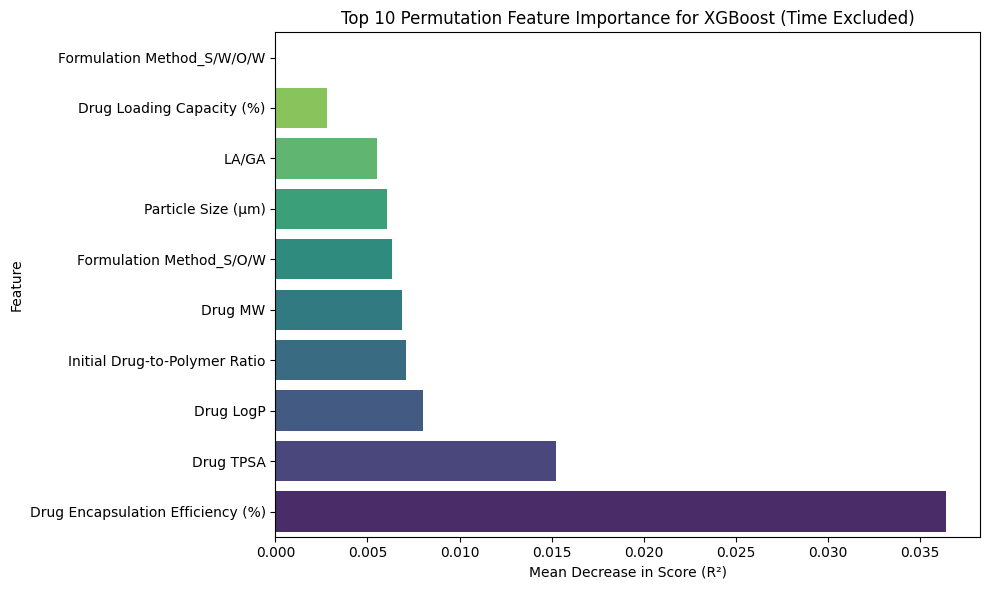

In [102]:

features_no_time = [f for f in X_test.columns if "time" not in f.lower()]

# Compute PFI for best_xgb

print("Calculating permutation importance for best_xgb...")

xgb_perm_importance = get_perm_importance(
    best_xgb,
    X_test,
    y_test,
    features_no_time        # time excluded
)

#  Sort and get top 10 features
sorted_xgb_importance = sorted(
    xgb_perm_importance.items(),
    key=lambda item: item[1],
    reverse=True
)

top_10_xgb_features = [item[0] for item in sorted_xgb_importance[:10]]
top_10_xgb_values   = [item[1] for item in sorted_xgb_importance[:10]]

print("\n--- Top 10 Permutation Feature Importance (best_xgb, Time Excluded) ---")
for f, v in zip(top_10_xgb_features, top_10_xgb_values):
    print(f"{f}: {v:.5f}")


#  Plotting top 10 PFI
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_xgb_values,
    y=top_10_xgb_features,
    palette='viridis'
)
plt.xlabel('Mean Decrease in Score (R²)')
plt.ylabel('Feature')
plt.title('Top 10 Permutation Feature Importance for XGBoost (Time Excluded)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## XGBOOST with PFI Feature Selection

In [103]:

# Sort PFI results (highest to lowest)
sorted_importance = sorted(
    xgb_perm_importance.items(),
    key=lambda x: x[1],
    reverse=True
)

# Select Top-10 from PFI
top_10_pfi_features = [feat for feat, score in sorted_importance[:10]]

# Automatically detect REAL time feature
time_cols = [c for c in X_train.columns if "time" in c.lower()]
if len(time_cols) == 0:
    raise ValueError("No time column found in X_train!")
time_col = time_cols[0]

# Add it if missing
if time_col not in top_10_pfi_features:
    top_10_pfi_features.append(time_col)

print("\nSelected features for final model (Top-10 PFI + Time):")
for f in top_10_pfi_features:
    print("  -", f)

# Subset train/test to these features
X_train_top10 = X_train[top_10_pfi_features].copy()
X_test_top10  = X_test[top_10_pfi_features].copy()

#Final XGBoost (using best hyperparameters)
final_xgb_top10 = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    subsample=0.8,
    reg_lambda=0.1,
    reg_alpha=0,
    n_estimators=300,
    min_child_weight=1,
    max_depth=6,
    learning_rate=0.03,
    gamma=0.3,
    colsample_bytree=0.6
)

final_xgb_top10.fit(X_train_top10, y_train)

# Evaluate final model
train_top10_metrics = get_regression_metrics(final_xgb_top10, X_train_top10, y_train)
test_top10_metrics  = get_regression_metrics(final_xgb_top10, X_test_top10,  y_test)

print("\nFinal XGB (Top-10 PFI + Time) - Train:", train_top10_metrics)
print("Final XGB (Top-10 PFI + Time) - Test :", test_top10_metrics)



Selected features for final model (Top-10 PFI + Time):
  - Drug Encapsulation Efficiency (%)
  - Drug TPSA
  - Drug LogP
  - Initial Drug-to-Polymer Ratio
  - Drug MW
  - Formulation Method_S/O/W
  - Particle Size (μm)
  - LA/GA
  - Drug Loading Capacity (%)
  - Formulation Method_S/W/O/W
  - Time (days)

Final XGB (Top-10 PFI + Time) - Train: {'r2': 0.8284287895803509, 'mse': 0.018610785820960936, 'mae': 0.10554779327033016, 'max_error': np.float64(0.656775356543396)}
Final XGB (Top-10 PFI + Time) - Test : {'r2': 0.6345194245231052, 'mse': 0.037412008147043124, 'mae': 0.1464778378599045, 'max_error': np.float64(0.679350285032898)}


## SHAP Analysis

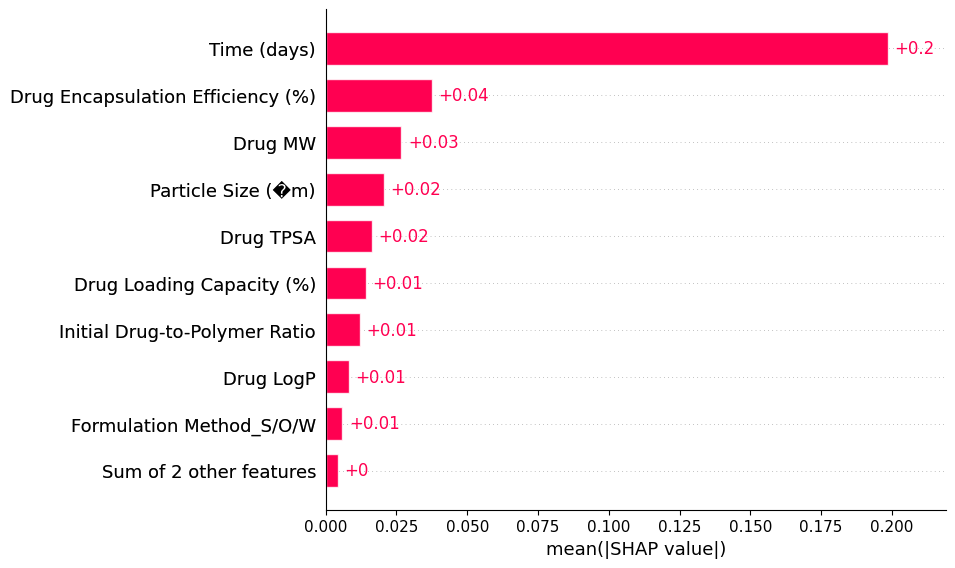

In [104]:
shap.plots.bar(shap_values)


## Beeswarm Plot

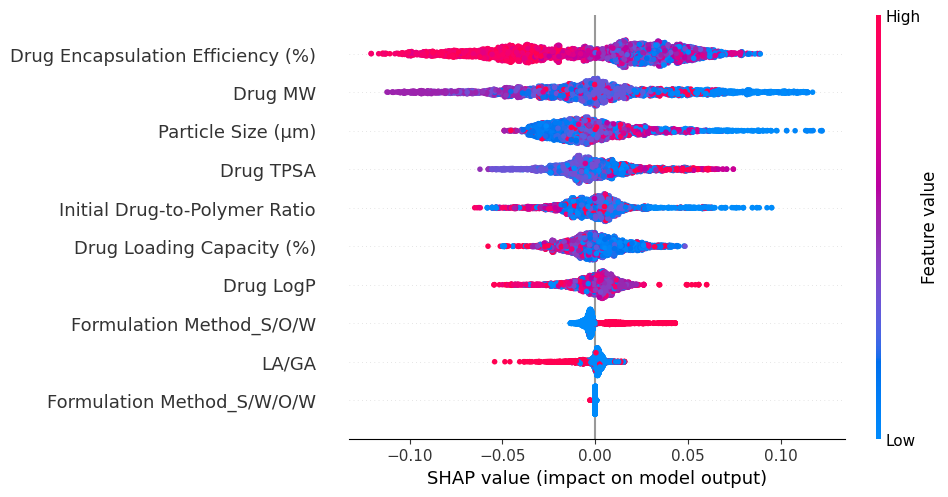

In [105]:
import numpy as np
import shap

#Original SHAP values
explainer = shap.TreeExplainer(final_xgb_top10)
shap_values = explainer(X_train_top10)

#Find the time column and its index
time_cols = [c for c in X_train_top10.columns if "time" in c.lower()]
time_col = time_cols[0]          # assume only one time column
time_idx = list(X_train_top10.columns).index(time_col)

#Build a mask that EXCLUDES the time column
mask = np.array([i != time_idx for i in range(len(X_train_top10.columns))])

#Create a new SHAP Explanation without time
shap_values_no_time = shap.Explanation(
    values       = shap_values.values[:, mask],
    base_values  = shap_values.base_values,
    data         = shap_values.data[:, mask],
    feature_names=[name for i, name in enumerate(shap_values.feature_names) if i != time_idx]
)

#Beeswarm plot WITHOUT time
shap.plots.beeswarm(shap_values_no_time)
